# Gyro Example on 10-22
## Cts system discretized to discrete KF

In [1]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
  !wget -O basic_material.py https://www.dropbox.com/s/o48uhuwah8n2xww/basic_material.py?dl=0
%run basic_material

try:
  %reload_ext autoreload
except:
  %load_ext autoreload
%autoreload 2

from numpy.random import randn
from numpy import eye, array, asarray, exp

from math import sqrt
from scipy.linalg import expm, solve_discrete_lyapunov, sqrtm
from scipy import linalg as la

SyntaxError: invalid syntax (basic_material.py, line 12)

# Summary -- Discrete Kalman Filter
$\newcommand{\jQ}{W}
\newcommand{\jP}{Q}
\newcommand{\njminus}{_{k|k-1}}
\newcommand{\sjminus}{_{k+1|k}}
\newcommand{\njplus}{_{k|k}}
\newcommand{\ojplus}{_{k-1|k-1}}
\newcommand{\bee}{\begin{enumerate}}
\newcommand{\eee}{\end{enumerate}}
\newcommand{\bea}{\begin{eqnarray}}
\newcommand{\eea}{\end{eqnarray}}
\newcommand{\beas}{\begin{eqnarray*}}
\newcommand{\eeas}{\end{eqnarray*}}
\newcommand{\ba}{\begin{array}}
\newcommand{\ea}{\end{array}}
\newcommand{\jbas}{\begin{align*}}
\newcommand{\njbxh}{\widehat{\mathbf{x}}}
\newcommand{\njbxt}{\tilde{\mathbf{x}}}
\newcommand{\njbxhn}{\hat{\mathbf{x}}}
\newcommand{\njbyh}{\widehat{\mathbf{y}}}
\newcommand{\njbu}{\mathbf{u}}
\newcommand{\njbf}{\mathbf{f}}
\newcommand{\njbg}{\mathbf{g}}
\newcommand{\njbh}{\mathbf{h}}
\newcommand{\njba}{\mathbf{a}}
\newcommand{\njbb}{\mathbf{b}}
\newcommand{\njbi}{\mathbf{i}}
\newcommand{\njbe}{\mathbf{e}}
\newcommand{\njbd}{\mathbf{d}}
\newcommand{\njbp}{\mathbf{p}}
\newcommand{\njbq}{\mathbf{q}}
\newcommand{\njbr}{\mathbf{r}}
\newcommand{\njby}{\mathbf{y}}
\newcommand{\njbv}{\mathbf{v}}
\newcommand{\njbw}{\mathbf{w}}
\newcommand{\njbx}{\mathbf{x}}
\newcommand{\njbX}{\mathbf{X}}
\newcommand{\njbY}{\mathbf{Y}}
\newcommand{\njbz}{\mathbf{z}}
\newcommand{\njbs}{\mathbf{s}}
\newcommand{\njbm}{\mathbf{m}}
\newcommand{\njbn}{\mathbf{n}}
\newcommand{\njbc}{\mathbf{C}}
\newcommand{\bt}{\begin{tabular}}
\newcommand{\et}{\end{tabular}}
\newcommand{\bq}{\begin{quote}}
\newcommand{\eq}{\end{quote}}
\newcommand{\bi}{\begin{itemize}}
\newcommand{\ei}{\end{itemize}}
\newcommand{\bee}{\begin{enumerate}}
\newcommand{\eee}{\end{enumerate}}
\newcommand{\bea}{\begin{eqnarray}}
\newcommand{\eea}{\end{eqnarray}}
\newcommand{\beas}{\begin{eqnarray*}}
\newcommand{\eeas}{\end{eqnarray*}}
\newcommand{\ba}{\begin{array}}
\newcommand{\ea}{\end{array}}
\newcommand{\jbas}{\begin{align*}}
\newcommand{\jeas}{\end{align*}}
\newcommand{\bff}{\begin{flushleft}}
\newcommand{\eff}{\end{flushleft}}
\newcommand{\bc}{\begin{center}}
\newcommand{\ec}{\end{center}}
\newcommand{\simn}{\stackrel{\min}{\sim}}
\newcommand{\njar}{\Rightarrow}$
Measurement update
\begin{eqnarray}
\jP\njplus &=&(I-L_kC_d)\jP\njminus \\
L_k&=&\jP\njplus C_d^TR_k^{-1}\\
\njbxh\njplus &=& \njbxh\njminus +L_k(\njby_k - C_c \njbxh\njminus )
\end{eqnarray}

Propagation (with deterministic inputs added)
\begin{eqnarray}
\jP\sjminus &=&A_d \jP\njplus A_d^T + \jQ_k \\
\njbxh\sjminus &=& A_d \njbxh\njplus  + B_{u_d}\njbu_k
\end{eqnarray}

Filter gains $L_k$ typically have an initial transient and then settle down to a constant when $A_d$, $C_d$, $\jQ_k$, and $R_k$ are all constant

Yields discrete **Riccati Equation** that is very
complicated to solve for even simple problems $\njar$ dlqe
$$
\jP^{ss}\njminus =A_d(\jP^{ss}\njminus -\jP^{ss}\njminus C_d^T[C_d\jP^{ss}\njminus C_d^T+R]^{-1}C_d\jP^{ss}\njminus )A_d^T + \jQ
$$


In [9]:
# algorithm for finding discrete noise (see 7-16)
# for a cts A,Bw,Bu
def DiscretizeW(A,Bw,Wc,Bu,dt=1):
    Nx = A.shape[0]
    S = np.zeros([2*Nx,2*Nx])
    S[0:Nx,0:Nx] = -A
    S[0:Nx,Nx:2*Nx] = np.multiply(Bw,Wc)@Bw.T

    S[Nx:2*Nx,Nx:2*Nx] = A.T
    CC = expm(S*dt)
    Ad = np.transpose(CC[Nx:2*Nx,Nx:2*Nx])
    Wd = Ad@CC[0:Nx,Nx:2*Nx]
    
    Nu = int(Bu.size/Nx)
    S = np.zeros([Nx+Nu,Nx+Nu])
    S[0:Nx,0:Nx] = A
    S[0:Nx,Nx:Nx+Nu] = Bu
    CC = expm(S*dt)
    Bd = CC[0:Nx,Nx:Nx+Nu]

    return Wd, Ad, Bd 

In [10]:
# Cts second order system that is discretized using dt 
alp = 1.0
Ts = 0.25 # 0.25 seconds between readings
Tf = 2 # final time
Nk = int(Tf/Ts) # number of steps in sim

Q0 = np.array([1]) # initial state uncertainty

A = np.array([-alp]) # cts A matrix
Nx = A.shape[0]
Bw = np.array([alp]) # cts noise input matrix
Wc = np.array([2.0]) # cts process noise
Rc = np.array([0.5*0.25]) # cts process noise
Wd, Ad, Bd = DiscretizeW(A,Bw,Wc,Bw,Ts) # convert to discrete
sWd = sqrtm(Wd)

# Sense position state
Cd = np.array([1.0]) # cts noise meas matrix
Rd = Rc/Ts # disc meas noise

In [11]:
Qdss = la.solve_discrete_are(Ad.T, Cd.T, Wd, Rd) # check transposes when using
print(f'Qdss = {Qdss[0,0]:.4f}')

Qdss = 0.5527


In [12]:
# One way to do recursion
Qdm = np.zeros((Nx,Nx,Nk+1))
Qdp = np.zeros((Nx,Nx,Nk+1))
Qdm[:,:,0] = Q0

for k in np.arange(Nk):
    Lk = Qdm[:,:,k]*Cd.T/(Cd*Qdm[:,:,k]*Cd.T+Rd) # uses Q[k|k-1]
    Qdp[:,:,k] = (np.eye(1) - Lk*Cd)*Qdm[:,:,k] # creates Q[k|k]
    #prop from k-1 to k 
    Qdm[:,:,k+1] = Ad * Qdp[:,:,k] * Ad.T + Wd  
else:
    Lk = Qdm[:,:,Nk]*Cd.T/(Cd*Qdm[:,:,Nk]*Cd.T+Rd) # uses Q[k|k-1]
    Qdp[:,:,Nk] = (np.eye(1) - Lk*Cd)*Qdm[:,:,Nk] # creates Q[k|k]


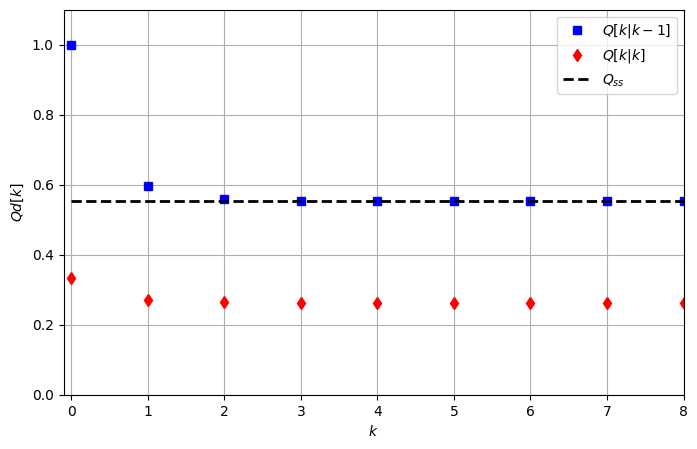

In [13]:
K=np.arange(0,Nk+1)
plt.figure(1,figsize=(8,5))
ax1 = plt.subplot(111)
ax1.plot(K,Qdm[0,0,:],'bs',label=r'$Q[k|k-1]$')
ax1.plot(K,Qdp[0,0,:],'rd',label=r'$Q[k|k]$')
ax1.plot([min(K), max(K)],[Qdss[0,0], Qdss[0,0]],'k--',label=r'$Q_{ss}$')
plt.ylabel(r'$Qd[k]$')
plt.xlabel(r'$k$')
plt.grid(True)
plt.legend(loc='best')
plt.xlim([0-0.1,Nk])
plt.ylim([0,1.1*Q0])
plt.tight_layout
plt.show()

In [14]:
# second way to do recursion
def func_kf(Q0,A,C,W,R):  
    Qdm = np.zeros((1,Nk+1))
    Qdp = np.zeros((1,Nk+1))

    II = np.zeros((1,2*Nk+2))
    Qcomb = np.zeros((1,2*Nk+2))
    Qdm[0,0] = Q0
    for k in range(Nk):
        Qdp[0,k] = Qdm[0,k] - Qdm[0,k]*C.T * (C*Qdm[0,k]*C.T + R)**(-1)*C*Qdm[0,k]
        Qdm[0,k+1] = A*Qdp[0,k]*A.T+W
        II[0,2*k] = k  # plotting index
        II[0,2*k+1] = k
        Qcomb[0,2*k] = Qdm[0,k]  # plotting variable
        Qcomb[0,2*k+1] = Qdp[0,k]
    else:
        Qdp[0,Nk] = Qdm[0,Nk-1] - Qdm[0,Nk-1]*C.T * (C*Qdm[0,Nk-1]*C.T + R)**(-1)*C*Qdm[0,Nk-1]
        II[0,2*Nk] = Nk  # plotting index
        II[0,2*Nk+1] = Nk
        Qcomb[0,2*Nk] = Qdm[0,Nk]  # plotting variable
        Qcomb[0,2*Nk+1] = Qdp[0,Nk]

    return Qdm, Qdp, II, Qcomb

Qdm, Qdp, II, Qcomb = func_kf(Q0/100,Ad,Cd,Wd,Rd)
Qdm2, Qdp2, II2, Qcomb2 = func_kf(Q0,Ad,Cd,Wd,Rd)


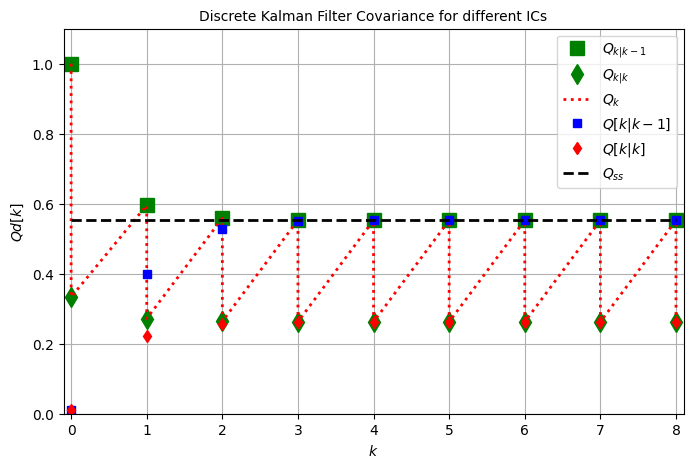

In [15]:
fig = plt.figure(6,figsize=(8, 5)) 
plt.plot(K,Qdm2[0,:],'gs',ms=10,label=r'$Q_{k|k-1}$')
plt.plot(K,Qdp2[0,:],'gd',ms=10,label=r'$Q_{k|k}$')
plt.plot(II2[0,:],Qcomb2[0,:],'r:',label=r'$Q_{k}$')

plt.plot(K,Qdm[0,:],'bs',label=r'$Q[k|k-1]$')
plt.plot(K,Qdp[0,:],'rd',label=r'$Q[k|k]$')
plt.plot([min(K), max(K)],[Qdss[0,0], Qdss[0,0]],'k--',label=r'$Q_{ss}$')
plt.ylabel(r'$Qd[k]$')
plt.xlabel(r'$k$')
plt.grid(True)
plt.legend(loc='best')
plt.xlim([0,Nk])
plt.ylim([0,1.1*Q0])

plt.title('Discrete Kalman Filter Covariance for different ICs')
plt.legend(loc='upper right')
plt.tight_layout
plt.xlim([-1e-1,Nk+1e-1])
plt.ylim([0,1.1*Q0])
plt.savefig("figs/fig10_22.png")
plt.show()
